# Blog feedback (David)
- https://archive.ics.uci.edu/ml/datasets/BlogFeedback
- very large samples (60021), large dimension (281)
- attribute characteristics: numeric

Using only 10 rows of the training set (due to performance)
### without preprocessing
- runtime: 27.005s
- best parameter settings: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500}
- train scores: TBD
- test scores: [mae] 12.814, [mse] 1662.049, [r2] -0.040

### with preprocessing 1
- preprocessing: standardized scaling
- runtime: 27.328
- best parameter settings: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500}
- train scores: TBD
- test scores: [mae] 11.985, [mse] 1647.030, [r2] -0.031

### with preprocessing 2
- preprocessing: standardized scaling, PCA down to 100 dimensions
- runtime: 31.536s
- best parameter settings: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500}
- train scores: TBD
- test scores: [mae] 15.412, [mse] 1605.100, [r2] -0.005

### Notes (by Moritz)
- from UCI: 
```0...50: Average, standard deviation, min, max and median of the Attributes 51...60 for the source of the current blog post. With source we mean the blog on which the post appeared. For example, myblog.blog.org would be the source of the post myblog.blog.org/post_2010_09_10```
    - could drop cols 0 (1) to 49 (50) as they contain summary vals of cols 50 (51) to 59 (60).
    - could drop cols 50 to 59 and aggregate per source

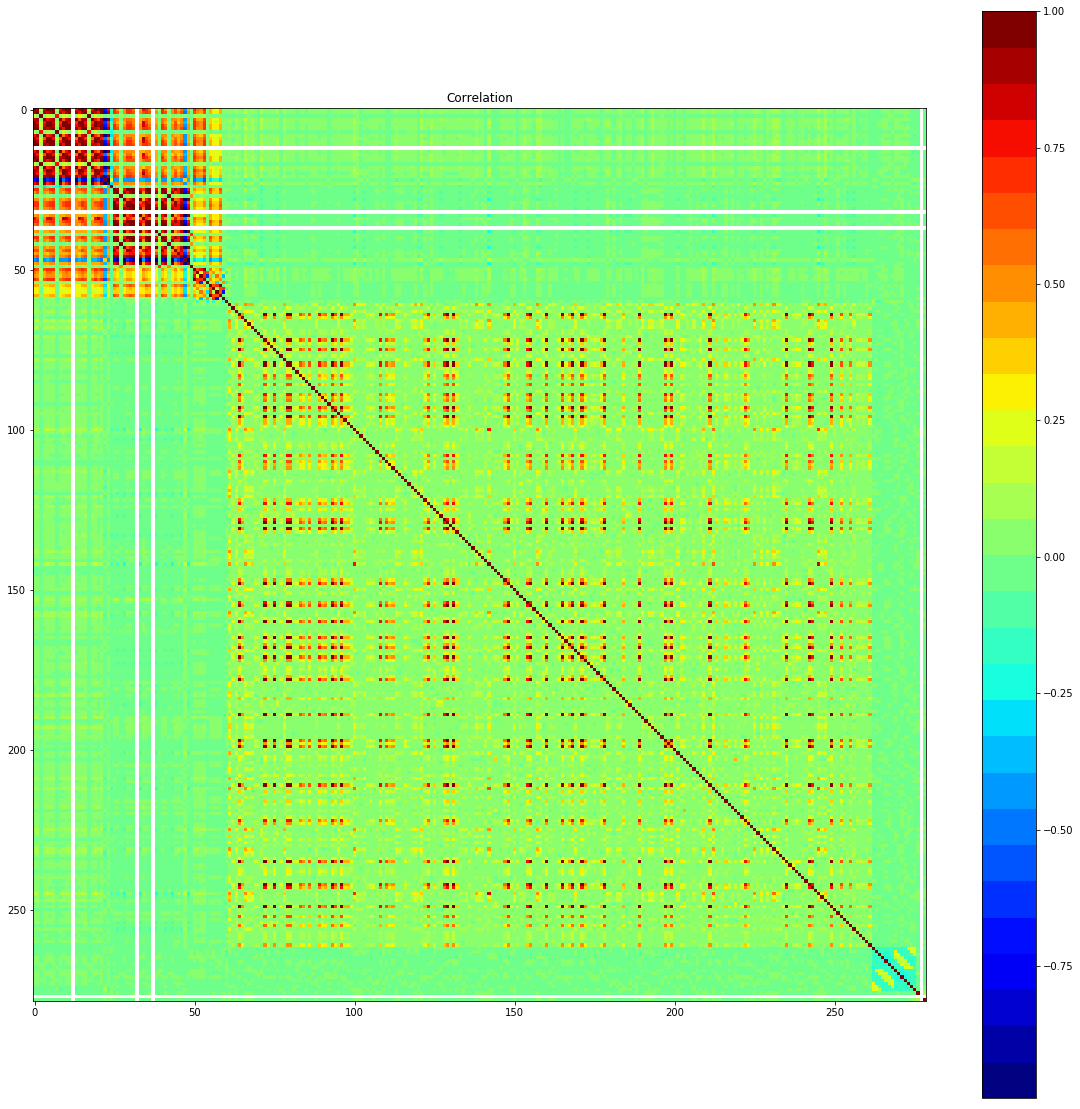

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:5085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


In [3]:
### Select data and train initial models

%run base.ipynb
%matplotlib inline

train_path = 'data/blog_feedback/blogData_train.csv'
test_path = 'data/blog_feedback/blogData_test-2012.02.01.00_00.csv'

train = pd.read_csv(train_path, header=None, sep = ",")
test = pd.read_csv(test_path, header=None, sep=",")

train_data = train.iloc[:,:279]
train_target = train.iloc[:,280]
test_data = test.iloc[:,:279]
test_target = test.iloc[:,280]

#display(train_data[:10])
#corr_data = train_data.iloc[:, 50:]
#correlation_matrix(corr_data, corr_data.columns)

# drop cols 0 to 50
train_data = train_data.iloc[:, 50:]
test_data = test_data.iloc[:, 50:]

train_data, test_data = scale_data(train_data, test_data)
#display(train_data[:10])
train_data, test_data = my_pca(train_data, test_data, 15)
#display(train_data[:10])

In [2]:
# Linear Regression
reg = linear_reg(train_data, train_target)
result = pd.DataFrame(reg.predict(test_data))

# TODO score

display(result)

R^2 value for model: 0.18577600945746253


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


,0
0,7.546172
1,4.469790
2,20.143554
3,6.823305
4,4.107219
5,4.662391
6,-4.143413
7,7.985730
8,-0.555557
9,4.869691


In [ ]:
# SVR
# params
param_grid = {
    'C': np.linspace(.2,1,5),
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'], # poly very slow
    'epsilon': np.linspace(0,.5,6),
    'gamma': ['auto', 'scale']
}

# run grid search
gs = run_svr(train_data, train_target, cv=5, param_grid=param_grid)

# predict
result = pd.DataFrame(gs.best_estimator_.predict(test_data))

# join id col
#result = pd.concat([X_test.reset_index()[['id']], result], axis='columns')
display(result)

GridSearch initializing...
SVR model in training...


In [7]:
# Gradient Boosted Decision Tree
param_fix = {'learning_rate': 0.01, 'loss': 'ls'}
cv = 10
#param_grid = {'n_estimators': [100, 500, 5]}
param_grid = {'n_estimators': (50, 100, 150, 200, 300, 400, 500), 'max_depth': (1, 2, 3, 4, 5), 'min_samples_split': (2,3,5)}

gbt = run_boosted_tree(train_data.iloc[:100,:], train_target[:100], test_data, test_target, param_fix, cv, param_grid)
#plot_scores(gbt.cv_results_)
#plot_training_deviance(gbt, test_data, test_target)

GridSearch initializing...
GradientBoostedRegressor model in training...
GradientBoostedRegressor model selected and fitted in 53.804 s

Best parameters selected by GridSearch: {'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 50}


In [3]:
### Test model

pred = gbt.predict(test_data)

# Metrics
mae = metrics.mean_absolute_error(test_target, pred)
mse = metrics.mean_squared_error(test_target, pred)
r2 = metrics.r2_score(test_target, pred)

print("\nMetrics: [mae] %.3f, [mse] %.3f, [r2] %.3f" % (mae, mse, r2))


Metrics: [mae] 14.948, [mse] 1592.432, [r2] 0.003
